In [1]:
!python --version

Python 3.8.0


# Package to install
!pip install rasterio
!pip install rioxarray
!pip install geopandas
!pip install earthpy

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import rasterio
import rioxarray as rxr
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
from matplotlib.colors import ListedColormap

In [2]:
img_path = './Data/Test1'
file = '2022-08-15-00_00_2022-08-15-23_59_Sentinel-2_L2A_True_color.tiff'

In [3]:
print(os.path.splitext(file)[0])

2022-08-15-00_00_2022-08-15-23_59_Sentinel-2_L2A_True_color


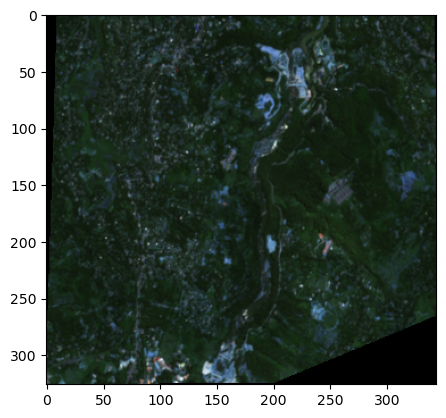

In [4]:
# Show true color img
img = cv2.imread(img_path+'/'+file)
plt.imshow(img)
plt.show()

In [5]:
red = '2022-08-15-00_00_2022-08-15-23_59_Sentinel-2_L2A_B04_(Raw).tiff'
nir = '2022-08-15-00_00_2022-08-15-23_59_Sentinel-2_L2A_B08_(Raw).tiff'

### NDVI Calculation

In [6]:
def ndvi(red,nir):
    
    # read the both .tiff files for red(B04) & nir (B08)
    red_file = rxr.open_rasterio(img_path+'/'+red)
    nir_file = rxr.open_rasterio(img_path+'/'+nir)
    
    # calculate the NDVI
    ndvi = es.normalized_diff(nir_file[0], red_file[0])
    
    # plot the results
    ep.plot_bands(ndvi,
              cmap='PiYG',
              scale=False,
              vmin=-1, vmax=1,
              title="Sentinel2 L2C Derived NDVI")
    plt.show()
    
    return ndvi

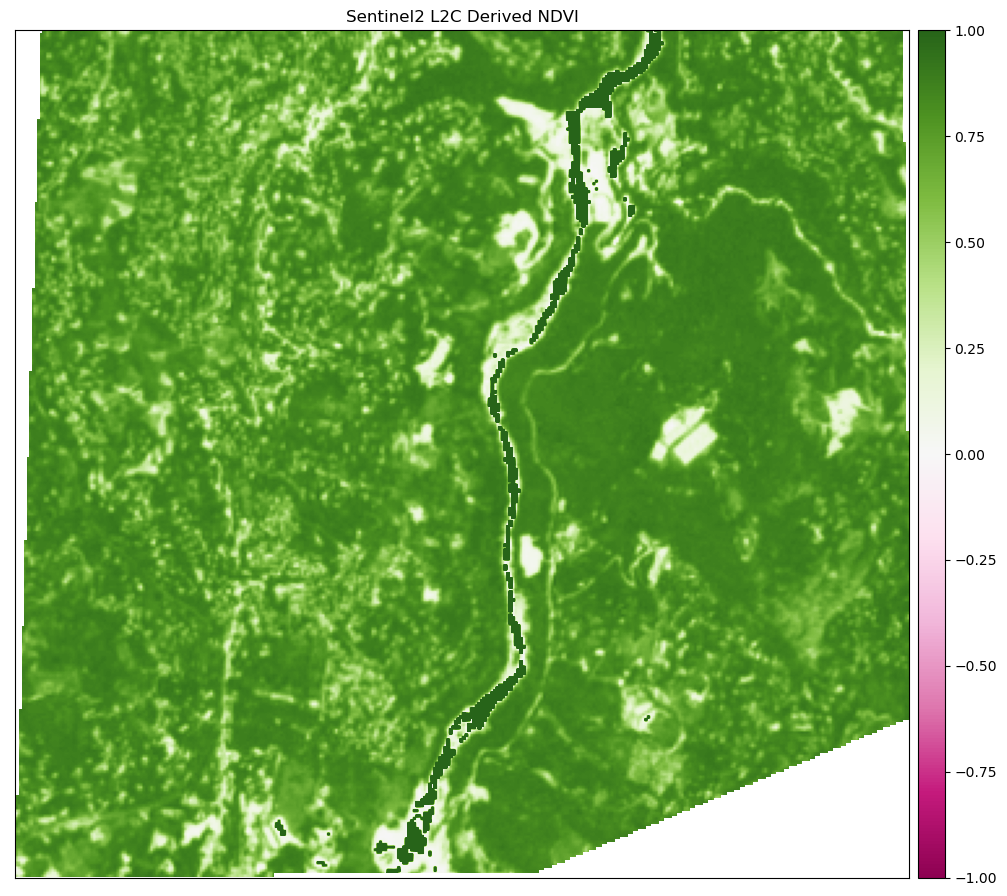

In [7]:
ndvi = ndvi(red,nir)

### Vegetation Classification

In [8]:
def veg_class(ndvi,save_path,file):
    
    # Create classes and apply to NDVI results
    ndvi_class_bins = [-np.inf, 0.6, 0.8, np.inf]
    ndvi_landsat_class = np.digitize(ndvi, ndvi_class_bins)

    # Apply the nodata mask to the newly classified NDVI data
    ndvi_landsat_class = np.ma.masked_where(np.ma.getmask(ndvi), 
                                            ndvi_landsat_class)
    #np.unique(ndvi_landsat_class)
    
    # Define color map
    nbr_colors = ["gray", "g", "gray"]
    nbr_cmap = ListedColormap(nbr_colors)

    # Define class names
    ndvi_cat_names = [
        "No Vegetation",
        "Vegetation",
        "No Vegetation"]

    # Get list of classes
    classes = np.unique(ndvi_landsat_class)
    classes = classes.tolist()
    
    # The mask returns a value of none in the classes. remove that
    classes = classes[0:3]

    # Plot your data
    fig, ax = plt.subplots()
    im = ax.imshow(ndvi_landsat_class, cmap=nbr_cmap)
    ax.set_axis_off()
    canvas = plt.gca().figure.canvas
    canvas.draw()
    data = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
    image = data.reshape(canvas.get_width_height()[::-1] + (3,))
    
    #save img
    veg_file = os.path.splitext(file)[0]+'_g'+'.png'
    plt.savefig(save_path+'/'+veg_file)
    print(veg_file+'\n'+"successfully saved!")
    
    return veg_file

2022-08-15-00_00_2022-08-15-23_59_Sentinel-2_L2A_True_color_g.png
successfully saved!


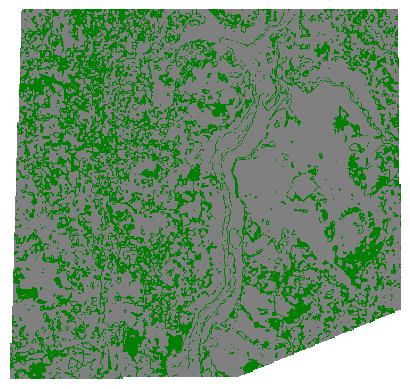

In [9]:
veg_file = veg_class(ndvi,img_path,file)

### Read Img

In [16]:
def read_img(path,file):
    img = cv2.imread(path+'/'+file)
    plt.imshow(img)
    plt.show()
    return img

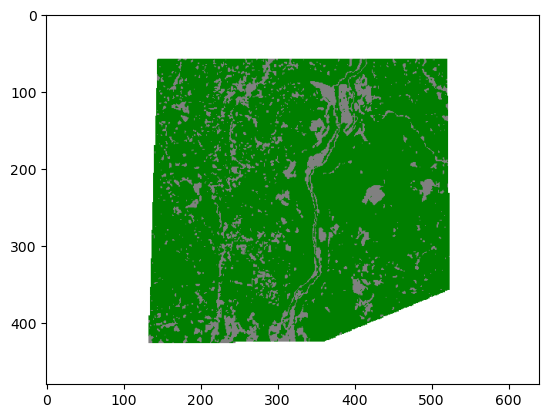

In [17]:
image = read_img(img_path,veg_file)

### Count green pixels

In [18]:
# convert to HSV
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
h,s,v = cv2.split(hsv)

# create mask for green color in hsv
lower = (50,100,100)
upper = (70,255,255)
mask = cv2.inRange(hsv, lower, upper)

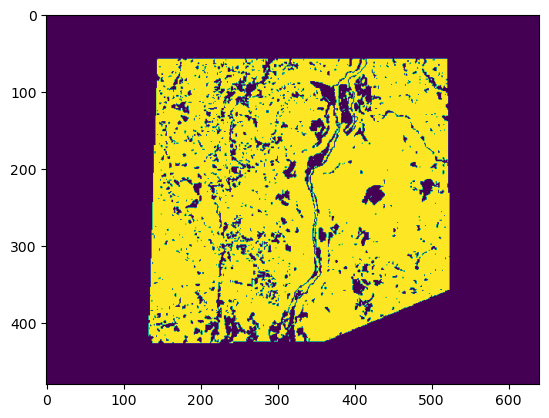

In [19]:
plt.imshow(mask)

In [20]:
# count non-zero pixels in mask
count=np.count_nonzero(mask)
print('count:', count)

count: 116410


In [21]:
# counting the number of pixels
number_of_white_pix = np.sum(mask == 255)
number_of_black_pix = np.sum(mask == 0)
  
print('Number of white pixels:', number_of_white_pix)
print('Number of black pixels:', number_of_black_pix)

Number of white pixels: 116410
Number of black pixels: 190790
